# Tutorial de Transfer Learning y Fine Tuning con Keras

Versión con celdas evaluadas.

GPT2: Diseño y Gestión de Proyectos en Data Science II.
[Máster en Data Science y Big Data](http://masterds.es/) de la [Universidad de Sevilla](http://www.us.es). 

25/06/2020. Profesor: [Miguel Ángel Martínez del Amor](http://www.cs.us.es/~mdelamor)

## Tabla de Contenidos

* [1. Importación de librerías](#transferimp)
* [2. El modelo InceptionV3](#inceparq)
* [3. Ejemplos de predicción](#transferej)
* [4. El dataset: Knifey-Spoony](#transferdata)
* [5. El canal de entrada](#transferinput)
* [6. Las clases del dataset](#transferclases)
* [7. Transfer Learning](#transfertl)
* [8. Fine Tuning](#transferft)
* [9. Conclusiones](#transferconclu)


Este tutorial muestra cómo usar la Red Neural Profunda pre-entrenada para la clasificación de imágenes. Primero, veremos una demostración detallada de cómo hacerlo, y posteriormente trabajaremos en un par de ejercicios.

En concreto vamos a reutilizar el modelo pre-entrenado de InceptionV3 para un conjunto de datos nuevo y distinto a ImageNet (Knifey-Spoony). Podrás ver más información sobre los modelos pre-entrenados en Keras en [este enlace](https://keras.io/applications/).

El modelo Inception v3 tardó semanas en entrenarse sobre ImageNet (formado por millones de imágenes) en un ordenador con 8 GPUs Tesla K40 que probablemente cuesta unos 30.000 euros, por lo que es casi imposible entrenarlo en un PC normal. En su lugar, descargaremos el modelo de Inception previamente entrenado y lo usaremos para clasificar las imágenes. El modelo Inception v3 tiene casi 25 millones de parámetros y utiliza 5.000 millones de operaciones de multiplicación para clasificar una sola imagen. En un PC moderno sin GPU, esto se puede hacer en una fracción de segundo por imagen.

Las capas densas son responsables de combinar los rasgos de las capas convolucionales y esto ayuda en la clasificación final. Así que cuando se utiliza el modelo InceptionV3 en otro conjunto de datos, es posible que tengamos que reemplazar todas las capas densas. En este caso quitaremos la capa densa original y la reemplazaremos por otra capa densa y una capa dropout para evitar el sobreajuste.

La diferencia entre Transfer Learning y Fine-Tuning es que en Transfer Learning sólo optimizamos los pesos de las nuevas capas de clasificación que hemos añadido, mientras que mantenemos los pesos del modelo original. En Fine-Tuning optimizamos tanto los pesos de las nuevas capas de clasificación que hemos añadido, como algunas o todas las capas del modelo InceptionV3.

## 1. Importación de librerías y funciones auxiliares <a class="anchor" id="transferimp"></a>

Vamos a importar algunas librerías auxiliares y definiremos funciones que vendrán bien para trabajar con el modelo.

In [1]:
# Antes de nada, si estás en Google Colab, evalúa esta celda:
import os
work_dir = "/content/TL-tutorial/"
if os.getcwd() != work_dir:
    !git clone https://github.com/miguelamda/TL-tutorial.git
os.chdir(work_dir)

Cloning into 'TL-tutorial'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 148 (delta 42), reused 20 (delta 9), pack-reused 63
Receiving objects: 100% (148/148), 28.89 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (58/58), done.


### 1.1 Librerías

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

A continuación la importación de la API de Keras. Comprueba como se hace la importación directamente desde TensorFlow.

In [3]:
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop

tf.__version__

Using TensorFlow backend.


'2.2.0'

Comprobemos si estamos usando GPU desde TensorFlow. Debería aparecer `/device:GPU:X`, donde X es un número (0, 1,...) según existen más GPUs en el sistema.

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

También podemos comprobar si tenemos una GPU de NVIDIA con el siguiente comando:

In [5]:
!nvidia-smi

Thu Jun 25 19:05:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |    219MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.2 Funciones auxiliares de ayuda

Para unir un directorio con una lista de nombres de fichero.

In [6]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

Para dibujar imágenes, definimos esta función que usa una gráfica con hasta 9 imágenes en un grid de 3x3, y escribe la clase de verdad y las predichas en cada imagen.

In [7]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Crea una figura con sub-gráficas.
    fig, axes = plt.subplots(3, 3)

    # Ajusta el espacio vertical.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Tipo de interpolación.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # Puede haber menos de 9 imágenes, nos aseguramos que no falle.
        if i < len(images):
            # Dibuja imagen.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Number de la true class.
            cls_true_name = class_names[cls_true[i]]

            # Muestra clases predichas y verdaderas.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Nombre de la clase predicha.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Muestra las clases con la etiqueta en el eje x.
            ax.set_xlabel(xlabel)
        
        # Elimina ticks en la gráfica.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Asegurar que la gráfica se muestra correctamente con gráficos múltiples
    # en una sola celda Notebook.
    plt.show()

Función para mostrar un matriz de confusión. La emplearemos para mostrar las frecuencias de las confusiones entre las clases por el predictor.

In [8]:
# Importa una función de sklearn para calcular la matriz de confusión.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred es un array del número de la clase predicha para
    # todas las imágenes del conjunto de test.

    # Obtiene la matriz de confusión usando sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class para el conjunto de test.
                          y_pred=cls_pred)  # Predicted class.

    print("Matriz de confusión:")
    
    # Imprime la matriz de confusión como texto.
    print(cm)
    
    # Imprime los nombres de clases para facilitar la referencia.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

Función para mostrar ejemplos de imagenes del conjunto de test que han sido mal clasificadas (errores).

In [9]:
def plot_example_errors(cls_pred):
    # cls_pred es un array del número de la clase predicha para
    # todas las imágenes en el conjunto de test.

    # Array booleano indicando si la clase predicha es incorrecta.
    incorrect = (cls_pred != cls_test)

    # Obtiene las rutas de ficheros para las imágenes que son clasificadas incorrectamente.
    image_paths = np.array(image_paths_test)[incorrect]

    # Carga las primeras 9 imágenes.
    images = load_images(image_paths=image_paths[0:9])
    
    # Obtiene las clases predichas para esas imágenes.
    cls_pred = cls_pred[incorrect]

    # Obtiene las clases de verdad para esas imágenes.
    cls_true = cls_test[incorrect]
    
    # Muestra las 9 imágenes que hemos cargado y sus correspondientes clases.
    # Tenemos solo 9 imágenes, por lo que no hace falta dividirlas otra vez.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

Función para calcular las clases pronosticadas de todo el conjunto de test y llamar a la función anterior para dibujar algunos ejemplos de imágenes mal clasificadas.

In [10]:
def example_errors(model=None):
    # El generador de datos de Keras para el conjunto de test se debe resetear
    # antes del procesamiento. Esto es porque el generador va a iterar
    # infintamente y mantendrá un índice interno en el dataset.
    # Por tanto, se podrá comenzar por el medio del conjunto de test si no lo
    # reseteamos primero. Esto imposibilita encajar las clases predichas con
    # las imágenes de entrada. Si reseteamos el generador, entonces siempre
    # compienza por el comienzo, así que sabemos exáctamente qué imágenes
    # de entrada se están usando.
    if model is None:
        model = new_model
        
    generator_test.reset()
    
    # Predecir las clases para todas las imágenes del conjunto de test.
    y_pred = model.predict_generator(generator_test,
                                      steps=steps_test)

    # Convertir las clases predichas de arrays a enteros.
    cls_pred = np.argmax(y_pred,axis=1)

    # Muestra los ejemplos de imágenes mal clasificados.
    plot_example_errors(cls_pred)
    
    # Muestra la matriz de confusión.
    print_confusion_matrix(cls_pred)

Función de ayuda para cargar imágenes. El conjunto de datos no se carga en la memoria, sino que tiene una lista de los archivos de las imágenes del conjunto de entrenamiento y otra lista de los archivos de las imágenes del conjunto de pruebas. Esta función de ayuda carga algunos archivos de imagen.

In [11]:
def load_images(image_paths):
    # Carga las imágenes de disco.
    images = [plt.imread(path) for path in image_paths]

    # Convierte a un array de numpy y lo devuelve.
    return np.asarray(images)

Función de ayuda para trazar el historial de entrenamiento. Esto traza la precisión de clasificación y los valores de pérdida registrados durante el entrenamiento con la API de Keras.

In [12]:
def plot_training_history(history):
    # Obtiene la precisión de clasificación y el valor de pérdida para el
    # conjunto de entrenamiento.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # También para el conjunto de validación (solo usamos el del conjunto de test).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Muestra el valor del accuracy y pérdida para el conjunto de entrenamiento.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Muestra el del conjunto de test.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Muestra el título y la leyenda.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Se asegura de mostrar la gráfica correctamente.
    plt.show()

## 2. El modelo InceptionV3 <a class="anchor" id="inceparq"></a>

La siguiente figura muestra cómo fluyen los datos en el modelo Inception v3, que es una Red Neural Convolucional con muchas capas y una estructura complicada. El [artículo](http://arxiv.org/pdf/1512.00567v3.pdf) ofrece más detalles sobre cómo se construye el modelo Inception y por qué se diseña de esa manera. Se puede ver la arquitectura de InceptionV3, la cual consiste en varias capas convolucionales (en realidad bloques de capas convolucionales múltiples), seguidas por algunas capas completamente conectadas (densas) y luego una capa de salida softmax para la clasificación. En la parte convolucional hay tres tipos de módulos: módulo A (con kernels de 5x5 implementados mediante kernels de 3x3, ahorrando parámetros), módulo B (con kernels de 7x7 implementados mediante kernels de 1x7), y módulo C (para alta dimensionalidad, con kernels de 3x3 implementados con kernels de 3x1).

Ten en cuenta que el modelo Inception tiene dos salidas softmax. Una que se usa durante el entrenamiento de la red neural como regularizador y la otra que se usa para clasificar imágenes después de que el entrenamiento haya terminado; es decir, para inferencia. Para entender mejor los detalles de la red, se puede leer este [artículo](https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c).

![11_inception_model.png](https://github.com/miguelamda/TL-tutorial/blob/master/images/11_inception_model.png?raw=1)

Lo siguiente crea una instancia del modelo InceptionV3 pre-entrenado usando la API de [Keras](https://keras.io/). Esto descarga automáticamente los archivos necesarios, si no los tiene ya en caché.

Como se ha comentado antes, el modelo InceptionV3 contiene una parte convolucional y una parte completamente conectada (o densa) que se utiliza para la clasificación. Si `include_top=True` entonces se descarga todo el modelo, que tiene unos 92 MB y unos 23 millones de parámetros. Si `include_top=False` entonces sólo se descarga la parte convolucional del modelo.

Intentaremos usar el modelo pre-entrenado para predecir la clase de algunas imágenes en nuestro nuevo conjunto de datos, así que tenemos que descargar el modelo completo, pero si tienes una conexión lenta a Internet, entonces puedes modificar el código de abajo para usar el modelo pre-entrenado más pequeño sin las capas de clasificación.

In [13]:
model = InceptionV3(include_top=True, weights='imagenet')

96116736/96112376 [==============================] - 8s 0us/step


## 3. Ejemplos de predicción <a class="anchor" id="transferej"></a>

Juguemos un poco con el modelo InceptionV3. Veamos predicciones sobre algunas imágenes de ejemplo, para entender mejor cómo funciona y cómo fue entrenado. Vamos a hacer uso de una función auxiliar que cargue y redimensione la imagen que le digamos para que pueda ser introducida en el modelo, así como para hacer la predicción real y mostrar el resultado.

In [14]:
from IPython.display import Image, display

def predict(image_path):
    # Carga y redimensiona la imagen usando PIL.
    img = PIL.Image.open(image_path)
    input_shape = model.layers[0].output_shape[1:3]
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Dibuja la imagen.
    #plt.imshow(img_resized)
    #plt.show()
    display(Image(image_path))

    # Convierte la imagen PIL a un numpy-array con la forma (shape) apropiada.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Usa el modelo InceptionV3 para hacer la predicción.
    # Esto devuelve un array con 1000 números, correspondientes a
    # las clases del dataset ImageNet.
    pred = model.predict(preprocess_input(img_array))
    
    # Decodifica la salida del modelo InceptionV3.
    pred_decoded = decode_predictions(pred)[0]

    # Imprime las predicciónes.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

### 3.1 Panda

Esta imagen de un panda se incluye en el archivo de datos de Inception. El modelo Inception está bastante seguro de que esta imagen muestra un panda, con una puntuación de clasificación de alrededor del 89% y la siguiente puntuación más alta es de sólo alrededor del 0,8% para un indri, que es otro animal exótico.

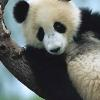

40960/35363 [==================================] - 0s 0us/step
88.89% : giant_panda
 0.41% : space_shuttle
 0.29% : indri
 0.16% : soccer_ball
 0.15% : lesser_panda


In [15]:
predict(image_path='images/cropped_panda.jpg')

### 3.2 Interpretación de las puntuaciones de clasificación

El resultado del modelo Inception es la llamada función **Softmax**. Las salidas softmax son a veces llamadas probabilidades porque están entre cero y uno, y también suman uno - igual que las probabilidades. Pero en realidad no son probabilidades en el sentido tradicional de la palabra, porque no provienen de experimentos repetidos.

Tal vez sea mejor llamar a los valores de salida de una red neuronal las *puntuaciones o rangos de clasificación*, porque indican con qué certeza cree la red que la imagen de entrada es de cada clase posible.

En el ejemplo anterior con la imagen de un panda, el modelo Inception dio una puntuación muy alta de alrededor del 89% para la clase panda, y las puntuaciones para las 999 clases posibles restantes estaban todas por debajo del 1%. Esto significa que el modelo de Inception estaba bastante seguro de que la imagen mostraba un panda y que las puntuaciones restantes por debajo del 1% debían considerarse como ruido. Por ejemplo, la octava puntuación más alta fue del 0,05% para un reloj digital, pero esto se debe probablemente más a la naturaleza imprecisa de las redes neuronales que a una indicación de que la imagen se parecía ligeramente a un reloj digital.

A veces el modelo Inception se confunde con la clase a la que pertenece una imagen, por lo que ninguna de las puntuaciones es realmente alta. A continuación se muestran ejemplos de ello.

### 3.3 Loro (Parrot)
#### Imagen Original

El modelo Inception está muy seguro (puntuación sobre 90%) de que esta imagen muestra un tipo de loro llamado guacamayo (macaw).

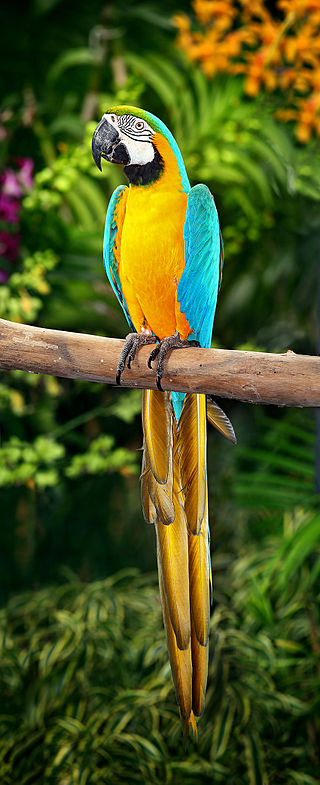

89.67% : macaw
 1.18% : bee_eater
 0.38% : jacamar
 0.33% : lorikeet
 0.27% : toucan


In [16]:
predict(image_path="images/parrot.jpg")

#### Imagen Redimensionada

El modelo Inception funciona con imágenes de entrada de 299 x 299 píxeles de tamaño. La imagen de arriba de un loro tiene en realidad 320 píxeles de ancho y 785 píxeles de alto, por lo que es redimensionada automáticamente por el modelo Inception.

Veamos cómo esta imagen ha sido redimensionada por Inception antes de ser introducida al modelo, usando esta función auxiliar.

In [17]:
def plot_resized_image(image_path):
    # Toma la imagen redimensionada del modelo Inception
    img = PIL.Image.open(image_path)
    input_shape = model.layers[0].output_shape[1:3]
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Muestra la imagen.
    plt.imshow(img_resized, interpolation='nearest')
    
    # Se asegura de que la gráfica se muestre.
    plt.show()

Esta es la imagen que se introduce en la red neuronal del modelo Inception. Podemos ver que ha sido aplastado para que sea cuadrado, y la resolución se ha reducido para que la imagen sea más pixelada y granulada.

En este caso, la imagen todavía muestra claramente un loro, pero algunas imágenes pueden distorsionarse tanto a partir de este ingenuo cambio de tamaño que puede que sea mejor cambiar el tamaño de las imágenes antes de introducirlas en el modelo Inception.

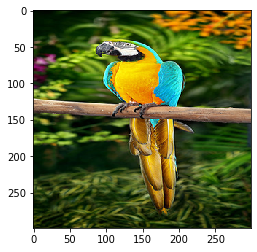

In [18]:
plot_resized_image(image_path="images/parrot.jpg")

#### Imagen Recortada por arriba

Esta imagen del loro se ha recortado manualmente a 299 x 299 píxeles y luego se ha introducido en el modelo Inception,
que sigue estando muy seguro (puntuación de alrededor del 90%) de que muestra un loro (guacamayo).

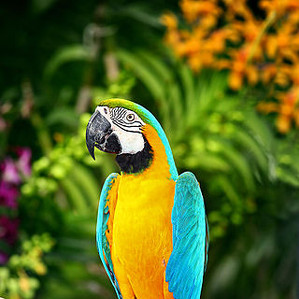

90.77% : macaw
 0.27% : African_grey
 0.25% : lorikeet
 0.12% : peacock
 0.12% : crash_helmet


In [19]:
predict(image_path="images/parrot_cropped1.jpg")

#### Imagen Recortada por el centro

A continuación otro recorte de la imagen del loro, esta vez mostrando su cuerpo sin cabeza ni cola. El modelo Inception pierde algo de confianza (puntuación de alrededor del 73%) de que muestra un loro guacamayo.

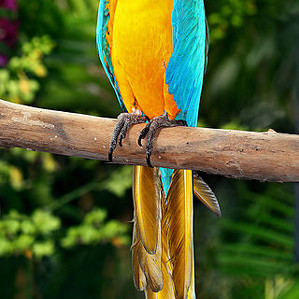

73.18% : macaw
 3.00% : bee_eater
 2.36% : lorikeet
 1.38% : jacamar
 1.10% : toucan


In [20]:
predict(image_path="images/parrot_cropped2.jpg")

#### Imagen Recortada por abajo

Esta imagen ha sido recortada por lo que sólo muestra la cola del loro. Ahora el modelo Inception está bastante confundido y piensa que la imagen podría mostrar un guacamayo pero con poca confianza (puntuación del 28%), o un bee_eater (puntuación de alrededor del 6%) que es otro ave exótica.

El modelo Inception también piensa que la imagen podría mostrar un saltamontes (leafhopeer, puntuación aproximada del 3.4%). Pero esta es una puntuación muy baja y debe interpretarse como un ruido poco fiable.

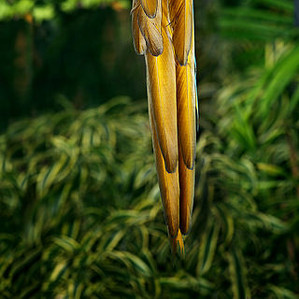

27.69% : macaw
 5.83% : bee_eater
 5.08% : lorikeet
 4.78% : jacamar
 3.41% : leafhopper


In [21]:
predict(image_path="images/parrot_cropped3.jpg")

#### Imagen Rellenada

La mejor manera de introducir imágenes en este modelo Inception, es rellenar la imagen para que sea cuadrada (en blanco a los lados) y luego redimensionarla a 299 x 299 píxeles, como este ejemplo del loro que está clasificado correctamente con una puntuación de alrededor del 96%.

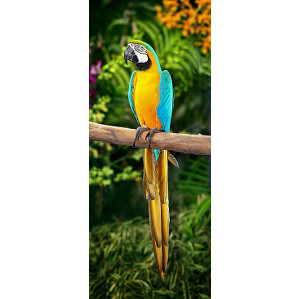

95.95% : macaw
 0.23% : bee_eater
 0.22% : lorikeet
 0.08% : toucan
 0.04% : jacamar


In [22]:
predict(image_path="images/parrot_padded.jpg")

### 3.4 Elon Musk

#### 299 x 299 píxeles

Esta imagen muestra al fundador de Tesla y SpaceX, Elon Musk. Pero el modelo de Inception está muy confundido sobre lo que muestra la imagen, prediciendo que puede mostrar una abaya (puntuación alrededor del 36%) o una sudadera (sweatshirt, puntuación alrededor del 15%). También piensa que la imagen podría mostrar una burbuja (bubble, puntuación de alrededor del 3%). Por lo tanto, el modelo Inception está confuso y las puntuaciones de la clasificación no son fiables.

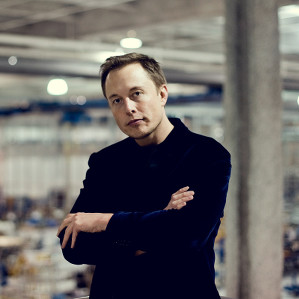

36.27% : abaya
14.95% : sweatshirt
 4.45% : suit
 3.12% : bubble
 2.85% : trench_coat


In [23]:
predict(image_path="images/elon_musk.jpg")

#### 100 x 100 píxeles

Si en su lugar usamos una imagen de 100 x 100 píxeles de Elon Musk, entonces el modelo de Inception sube su confianza en que se trata de una abaya (puntuación del 55%) o de una gabardina (trench_coat, puntuación alrededor del 12%). Así que ahora el modelo Inception tiene predicciones algo diferentes, pero sigue estando muy confuso.

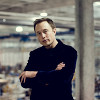

55.60% : abaya
12.51% : trench_coat
10.23% : suit
 5.21% : sweatshirt
 1.01% : cloak


In [24]:
predict(image_path="images/elon_musk_100x100.jpg")

El modelo Inception escala automáticamente el tamaño de esta imagen de 100 x 100 a 299 x 299 píxeles, que se muestra aquí. Observa lo pixelado y granuloso que realmente es, aunque un humano puede ver fácilmente que esta es la imagen de un hombre con los brazos cruzados.

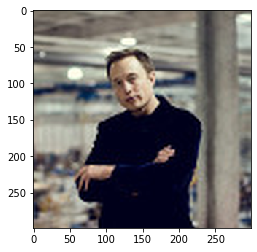

In [25]:
plot_resized_image(image_path="images/elon_musk_100x100.jpg")

### 3.5 Willy Wonka 

#### Gene Wilder

Esta imagen muestra al actor Gene Wilder interpretando a Willy Wonka en la versión de la película de 1971. El modelo Inception está muy seguro de que la imagen muestra una pajarita (bow tie, puntuación de alrededor del 99%), lo que es cierto, pero un humano probablemente diría que esta imagen muestra a una persona.

La razón podría ser que el modelo Inception fue entrenado en imágenes de personas con pajaritas que fueron clasificadas como pajaritas en lugar de personas. Así que tal vez el problema es que el nombre de la clase debería ser "persona con pajarita" en lugar de sólo "pajarita".

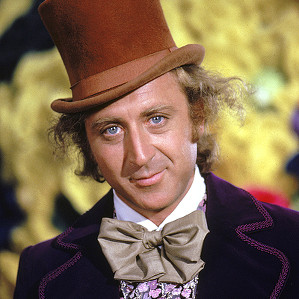

99.62% : bow_tie
 0.15% : cowboy_hat
 0.02% : sombrero
 0.01% : pomegranate
 0.01% : feather_boa


In [26]:
predict(image_path="images/willy_wonka_old.jpg")

#### Johnny Depp

Esta imagen muestra al actor Johnny Depp interpretando a Willy Wonka en la versión de 2005 de la película. El modelo Inception piensa que esta imagen muestra "gafas de sol" (sunglasses, puntuación aproximada del 66%) o "cristal para gafas de sol" (sunglass, puntuación aproximada del 30%). Una vez más, es cierto que la imagen muestra gafas de sol, pero un humano probablemente habría dicho que esta imagen muestra a una persona.

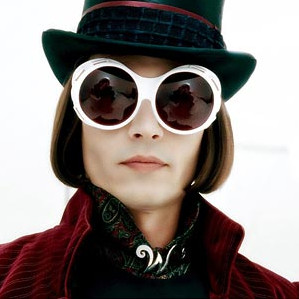

66.25% : sunglasses
30.83% : sunglass
 0.24% : stole
 0.14% : wig
 0.08% : velvet


In [27]:
predict(image_path="images/willy_wonka_new.jpg")

### 3.6 Conclusión <a class="anchor" id="incepconclu"></a>

En este apartado hemos demostrado cómo usar el modelo Inception v3 preentrenado. Un ordenador muy caro puede tardar varias semanas en entrenar el modelo Inception, pero podemos descargar el modelo terminado de Internet y usarlo en un PC normal para clasificar las imágenes.

Desafortunadamente, el modelo Inception parece tener problemas para reconocer a las personas. Esto puede deberse al conjunto de entrenamiento que se utilizó. Ya se han publicado versiones más recientes del modelo Inception, pero es probable que también estén capacitados en el mismo conjunto de datos y, por lo tanto, también pueden tener problemas para reconocer a las personas. Se espera que los modelos futuros sean entrenados para reconocer objetos comunes como las personas.

## 4. El Dataset: Knifey-Spoony <a class="anchor" id="transferdata"></a>

Para demostrar como usar transfer learning y fine tuning en este tutorial, usaremos un conjunto de datos llamado [Knifey-Spoony](https://github.com/Hvass-Labs/knifey-spoony) que contiene miles de imágenes de cuchillos, cucharas y tenedores sobre unos cuantos fondos diferentes. El conjunto de entrenamiento (training) contiene 4.170 imágenes y el de pruebas (test) 530 imágenes. Las clases se denominan knifey, spoony y forky (cuchillos, cucharas y tenedores) como referencia a [Los Simpsons](https://www.youtube.com/watch?v=mcE0aAhbVFc).

Las imágenes en el conjunto de datos knifey-spoony fueron creadas a partir de archivos de vídeo usando un pequeño [script de Python](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/convert.py) que se ejecuta en Linux (requiere el programa `avconv` para la conversión de videos a imágenes). Esto le permite crear fácilmente conjuntos de datos muy grandes con miles de imágenes de sólo unos minutos de grabaciones de vídeo.

In [28]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/mcE0aAhbVFc" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

### 4.1 Descarga del dataset

La descarga y la extracción del dataset ya viene automatizado en el fichero [`knifey.py`](./knifey.py). Las dimensiones de los datos ya están definidos en el módulo `knifey`, por lo que tan solo necesitamos importarlo (asegúrate de tenerlo en la carpeta de trabajo).

In [29]:
# Carga el dataset empleando el fichero kinfey.py
import knifey

Descarga y extrae el dataset si aún no se ha hecho. Ocupa unos 22 MB. A continuación, mostramos el contenido de la carpeta extraida.

In [30]:
knifey.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [31]:
!echo "El contenido de la carpeta es: "
!ls data/knifey-spoony
!echo "Por ejemplo, la carpeta forky contiene: "
!ls data/knifey-spoony/forky

El contenido de la carpeta es: 
forky  knifey  knifey-spoony.tar.gz  README.md	spoony
Por ejemplo, la carpeta forky contiene: 
forky-01-0001.jpg  forky-02-0049.jpg  forky-03-0113.jpg  forky-04-0191.jpg
forky-01-0002.jpg  forky-02-0050.jpg  forky-03-0114.jpg  forky-04-0192.jpg
forky-01-0003.jpg  forky-02-0051.jpg  forky-03-0115.jpg  forky-04-0193.jpg
forky-01-0004.jpg  forky-02-0052.jpg  forky-03-0116.jpg  forky-05-0001.jpg
forky-01-0005.jpg  forky-02-0053.jpg  forky-03-0123.jpg  forky-05-0002.jpg
forky-01-0006.jpg  forky-02-0054.jpg  forky-03-0124.jpg  forky-05-0003.jpg
forky-01-0007.jpg  forky-02-0055.jpg  forky-03-0125.jpg  forky-05-0004.jpg
forky-01-0008.jpg  forky-02-0056.jpg  forky-03-0126.jpg  forky-05-0005.jpg
forky-01-0009.jpg  forky-02-0057.jpg  forky-03-0127.jpg  forky-05-0006.jpg
forky-01-0010.jpg  forky-02-0058.jpg  forky-03-0128.jpg  forky-05-0007.jpg
forky-01-0011.jpg  forky-02-0059.jpg  forky-03-0129.jpg  forky-05-0008.jpg
forky-01-0012.jpg  forky-02-0060.jpg  forky-03-0

### 4.2 Redistribución del dataset 

Este dataset tiene una estructura de directoros distinta que la requerida por Keras:
* train
 * knifey
 * forky
 * spoony
* test
 * knifey
 * forky
 * spoony
* val (opcional)
 * knifey
 * forky
 * spoony

Por tanto copiaremos los ficheros en directorios separados para los conjuntos de pruebas (training) y pruebas (test). Esto ya está automatizado con la función copy_files.

In [32]:
knifey.copy_files()

Creating dataset from the files in: data/knifey-spoony/
- Data saved to cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


Finalmente, extraemos los directorios donde están las imágenes.

In [33]:
train_dir = knifey.train_dir
test_dir = knifey.test_dir

## 5. El Canal de Entrada <a class="anchor" id="transferinput"></a>

La API de Keras tiene su propia manera de crear el pipeline de entrada para entrenar un modelo usando ficheros.

Primero necesitamos saber la forma de los tensores esperados como entrada por el modelo InceptionV3 pre-entrenado. En este caso se trata de imágenes de forma 299 x 299 x 3.

In [34]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(299, 299)

Keras utiliza un llamado *generador de datos* para introducir datos en la red neuronal, que iterará sobre los datos durante toda la eternidad.

Tenemos un pequeño conjunto de entrenamiento, así que el generador ayudará a inflar artificialmente su tamaño haciendo varias transformaciones en las imágenes. Utilizaremos un generador de datos incorporado que puede realizar estas transformaciones aleatorias. Esto también se llama **aumentado de datos** (data augmentation).

Busca en la [ayuda de Keras](https://keras.io/preprocessing/image/) qué parámetros se pueden configurar en el generador de datos.

In [35]:
datagen_train = ImageDataGenerator(
      #rescale=1./255, # No hace falta normalizar, esto ya lo hace preprocess_input de inception_v3
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest',
      preprocessing_function=preprocess_input)  # Esta función es específica para inception_v3

También necesitamos un generador de datos para el conjunto de test, pero esto no debería hacer ninguna transformación en las imágenes porque queremos saber la precisión exacta de la clasificación en esas imágenes específicas. Así que simplemente aplicamos el preprocesamiento correspondiente al modelo.

In [36]:
datagen_test = ImageDataGenerator(#rescale=1./255,
      preprocessing_function=preprocess_input)

Los generadores de datos devolverán batches (lotes) de imágenes. Debido a que el modelo InceptionV3 es muy grande, el tamaño del batch no puede ser demasiado grande, ya que de lo contrario nos quedaremos sin RAM en la GPU.

In [37]:
batch_size = 20

Podemos guardar las imágenes transformadas aleatoriamente durante el entrenamiento, para comprobar si han sido demasiado distorsionadas, por lo que tendríamos que ajustar los parámetros del generador de datos anterior.

In [38]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

Ahora creamos el generador de datos real que leerá los archivos del disco, redimensionará las imágenes y devolverá un lote aleatorio.

Es un poco incómodo que la construcción del generador de datos se divida en estos dos pasos, pero probablemente se deba a que hay diferentes tipos de generadores de datos disponibles para diferentes tipos de datos (imágenes, texto, etc.) y fuentes (memoria o disco).

In [39]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 4170 images belonging to 3 classes.


El generador de datos para el conjunto de test no debería transformar y mezclar las imágenes.

In [40]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 530 images belonging to 3 classes.


Debido a que los generadores de datos iteran para siempre, necesitamos especificar el número de pasos a realizar durante la evaluación y predicción en el conjunto de pruebas. Debido a que nuestro conjunto de pruebas contiene 530 imágenes y el tamaño del batch está configurado en 20, el número de pasos es 26,5 para un procesamiento completo del conjunto de pruebas. Por eso necesitamos reiniciar el contador del generador de datos en la función `example_errors()` de arriba, para que siempre comience a procesar desde el principio del conjunto de pruebas.

In [41]:
steps_test = generator_test.n / batch_size
steps_test

26.5

## 6. Clases del Conjunto de Datos <a class="anchor" id="transferclases"></a>

A continuación vamos a obtener las clases del dataset, y vamos a visualizar qué hace Inception cuando intenta predecir su clasificación. ¿Será capaz de detectar una cuchara?

Obtengamos las rutas de los ficheros para todas las imágenes en los conjuntos de entrenamiento y de pruebas. Nos vendrá bien para las funciones auxiliares para visualizar ejemplos del conjunto de entrenamiento y de test.

In [42]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Obtengamos también las clasificaciones reales (el número correspondiente) de cada imagen en los conjuntos de training y test.

In [43]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Obtengamos los nombres correspondientes de las clases del dataset.

In [44]:
class_names = list(generator_train.class_indices.keys())
class_names

['forky', 'knifey', 'spoony']

Por último, obtener el número de clases en el dataset.

In [45]:
num_classes = generator_train.num_classes
num_classes

3

Mostremos algunas imágenes para ver si los datos son correctos.

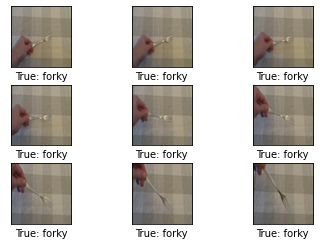

In [46]:
# Carga las primeras imágenes del conjunto de training
images = load_images(image_paths=image_paths_train[0:9])

# Obtiene las clases verdaderas de cada una de esas imágenes.
cls_true = cls_train[0:9]

# Muestra las imágenes y las etiquetas con la función auxiliar correspondiente.
plot_images(images=images, cls_true=cls_true, smooth=True)

El conjunto de datos Knifey-Spoony está bastante desequilibrado porque tiene pocas imágenes de tenedores, más imágenes de cuchillos y muchas más imágenes de cucharas. Esto puede causar un problema durante el entrenamiento porque a la red neural se le mostrará muchos más ejemplos de cucharas que de tenedores, por lo que puede llegar a ser mejor en el reconocimiento de las cucharas.

Aquí usamos scikit-learn para calcular **pesos** que equilibrarán adecuadamente el conjunto de datos. Estos pesos se aplican al gradiente para cada imagen del lote durante el entrenamiento, de manera que se pueda escalar su influencia en el gradiente global del lote.

In [47]:
from sklearn.utils.class_weight import compute_class_weight

In [48]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

Observa que el peso es de aproximadamente 1,398 para la clase tenedor y sólo 0,707 para la clase cuchara. Esto se debe a que hay menos imágenes para la clase tenedor, por lo que el gradiente debe ser amplificado para esas imágenes, mientras que el gradiente debe ser bajado para las imágenes de cuchara.

In [49]:
class_weight

array([1.39839034, 1.14876033, 0.70701933])

In [50]:
class_names

['forky', 'knifey', 'spoony']

Ahora sí, podemos usar el modelo InceptionV3 para predecir la clase de una de las imágenes en nuestro nuevo conjunto de entrenamiento. 

El modelo está muy confundido sobre esta imagen y no puede hacer una buena clasificación. Con un 11,79% de confianza cree que se trata de una red para mosquitos (mosquito_net). Quizás no le falte razón, pero está perdiendo la perspectiva del tenedor.

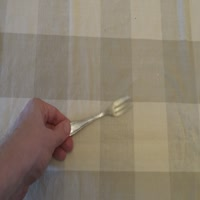

11.79% : mosquito_net
 4.54% : racket
 4.34% : handkerchief
 3.85% : lab_coat
 2.99% : window_screen


In [51]:
predict(image_path=image_paths_train[0])

Podemos intentarlo con otra imagen en nuestro nuevo set de entrenamiento, pero el modelo todavía está confundido.

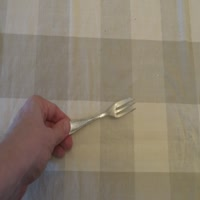

11.54% : racket
 7.41% : handkerchief
 6.70% : mosquito_net
 6.66% : window_screen
 5.61% : quill


In [52]:
predict(image_path=image_paths_train[1])

También podemos probar una imagen de nuestro nuevo conjunto de pruebas, y de nuevo el modelo InceptionV3 está muy confundido. A lo máximo que llega con un 12,23%, es una espátula (spatula).

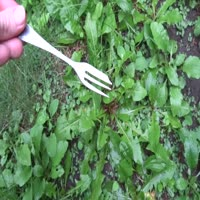

12.23% : spatula
 5.72% : quill
 5.23% : wooden_spoon
 2.72% : ladle
 2.62% : paddle


In [53]:
predict(image_path=image_paths_test[0])

Podemos concluir que el modelo InceptionV3 pre-entrenado no nos vale para trabajar con este nuevo dataset. Pero quizás podamos reutilizar parte del aprendizaje para esta nueva tarea.

## 7. Transfer Learning <a class="anchor" id="transfertl"></a>

El modelo InceptionV3 preentrenado no pudo clasificar las imágenes del conjunto de datos Knifey-Spoony. La razón es quizás que el modelo fue entrenado en el dataset ImageNet, que puede no haber contenido muchas imágenes de cubiertos.

Las capas inferiores de una Red Neural Convolucional pueden reconocer muchas formas o características diferentes en una imagen. Son las últimas capas completamente conectadas las que combinan estas características en la clasificación de una imagen completa. Así que podemos intentar redirigir la salida de la última capa convolucional del modelo InceptionV3 a una nueva red neuronal completamente conectada *(fully-connected)* que creamos para hacer la clasificación en el conjunto de datos de Knifey-Spoony.

Primero imprimimos un resumen del modelo InceptionV3 para poder ver los nombres y tipos de sus capas, así como las formas de los tensores que fluyen entre las capas. 

In [54]:
model = InceptionV3(include_top=False, weights='imagenet')

model.summary()

87916544/87910968 [==============================] - 8s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
______________________

Es muy sencillo crear un nuevo modelo usando la API de Keras. Primero tomamos la parte del modelo InceptionV3 desde su capa de salida (capa de transferencia). Podemos llamarlo el modelo convolucional, porque consiste en todas las capas convolucionales del modelo InceptionV3. Después aplanamos la salida convolucional con una función de pooling global, añadiremos una capa densa, después una capa de dropout para evitar sobreajuste, y finalmente la capa de clasificación. Puedes ver en Keras qué funciones hay que utilizar para hacer transfer learning: https://keras.io/api/applications/.

In [55]:
x = model.output

# Aplanamos la salida del modelo InceptionV3 dado que ésta viene
# de una capa convolucional.
x = GlobalAveragePooling2D()(x)

# Añade una capa densa (es decir, totalmente conectada o fully-connected).
# Esto es para combinar las características que el modelo ha
# reconocido en la imagen.
x = Dense(1024, activation='relu')(x)

# Añade una capa dropout el cual prevendrá el sobreajuste y mejorará
# la capacidad de generalización en datos desconocidos (es decir, el 
# conjunto de test)
x = Dropout(0.5)(x)

# Añade la capa final para la clasificación real, usando softmax.
predictions = Dense(num_classes, activation='softmax')(x)

# Finalmente, el modelo nuevo que vamos a entrenar
new_model = Model(inputs=model.input, outputs=predictions)

Por ejemplo, podemos utilizar el optimizador RMSprop con una tasa de aprendizaje bastante baja. La tasa de aprendizaje podría ser mayor, pero si se intenta entrenar más capas del modelo original InceptionV3, entonces la velocidad de aprendizaje debería ser bastante baja, de lo contrario los pesos preentrenados del modelo InceptionV3 se distorsionarán y no podrá aprender.

In [56]:
optimizer = RMSprop(lr=1e-4)

Tenemos 3 clases disjuntas en el Knifey-Spoony dataset. Es decir, estamos en un problema de clasificación multiclase, así que necesitamos usar la siguiente **función de pérdida** (loss function).

In [57]:
loss = 'categorical_crossentropy'

La única **métrica de rendimiento** en la que estamos interesados es en la precisión de clasificación (clasiffication accuracy).

In [58]:
metrics = ['categorical_accuracy']

Función auxiliar para imprimir si la capa en el modelo InceptionV3 debe ser entrenada.

In [59]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

Por defecto, todas las capas del modelo InceptionV3 son entrenables.

In [60]:
print_layer_trainable()

False:	input_2
True:	conv2d_95
True:	batch_normalization_95
True:	activation_95
True:	conv2d_96
True:	batch_normalization_96
True:	activation_96
True:	conv2d_97
True:	batch_normalization_97
True:	activation_97
True:	max_pooling2d_5
True:	conv2d_98
True:	batch_normalization_98
True:	activation_98
True:	conv2d_99
True:	batch_normalization_99
True:	activation_99
True:	max_pooling2d_6
True:	conv2d_103
True:	batch_normalization_103
True:	activation_103
True:	conv2d_101
True:	conv2d_104
True:	batch_normalization_101
True:	batch_normalization_104
True:	activation_101
True:	activation_104
True:	average_pooling2d_10
True:	conv2d_100
True:	conv2d_102
True:	conv2d_105
True:	conv2d_106
True:	batch_normalization_100
True:	batch_normalization_102
True:	batch_normalization_105
True:	batch_normalization_106
True:	activation_100
True:	activation_102
True:	activation_105
True:	activation_106
True:	mixed0
True:	conv2d_110
True:	batch_normalization_110
True:	activation_110
True:	conv2d_108
True:	conv2d_11

En transfer learning estamos inicialmente interesados tan solo en reusar el modelo InceptionV3 tal cual, como un **extractor de características**, por lo que deshabilitaremos el entrenamiento en todas sus capas.

In [61]:
model.trainable = False

In [62]:
for layer in model.layers:
    layer.trainable = False

In [63]:
print_layer_trainable()

False:	input_2
False:	conv2d_95
False:	batch_normalization_95
False:	activation_95
False:	conv2d_96
False:	batch_normalization_96
False:	activation_96
False:	conv2d_97
False:	batch_normalization_97
False:	activation_97
False:	max_pooling2d_5
False:	conv2d_98
False:	batch_normalization_98
False:	activation_98
False:	conv2d_99
False:	batch_normalization_99
False:	activation_99
False:	max_pooling2d_6
False:	conv2d_103
False:	batch_normalization_103
False:	activation_103
False:	conv2d_101
False:	conv2d_104
False:	batch_normalization_101
False:	batch_normalization_104
False:	activation_101
False:	activation_104
False:	average_pooling2d_10
False:	conv2d_100
False:	conv2d_102
False:	conv2d_105
False:	conv2d_106
False:	batch_normalization_100
False:	batch_normalization_102
False:	batch_normalization_105
False:	batch_normalization_106
False:	activation_100
False:	activation_102
False:	activation_105
False:	activation_106
False:	mixed0
False:	conv2d_110
False:	batch_normalization_110
False:	acti

Una vez que hayamos cambiado si las capas del modelos son entrenables, necesitamos compilarlo para que los cambios surtan efecto.

In [64]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Una **época** (epoch) normalmente significa un procesamiento completo del conjunto de entrenamiento. Pero el generador de datos que creamos arriba, producirá batches de datos de entrenamiento para la eternidad. Por lo tanto, necesitamos definir el número de pasos que queremos ejecutar para cada "época" y este número se multiplica por el tamaño de batch definido anteriormente. En este caso tenemos 100 pasos por época y un tamaño de batch de 20, por lo que la "época" consiste en 2.000 imágenes aleatorias del conjunto de entrenamiento. Nosotros ejecutaremos 20 de esas "épocas".

La razón por la que se eligieron estos números en particular, fue porque parecían ser suficientes para entrenar con este modelo y el conjunto de datos en particular, lo que no llevó mucho tiempo, y resultó en 20 puntos de datos (uno para cada "época") que se pueden mostrar después.

In [65]:
epochs = 20
steps_per_epoch = 100

A continuación entrenamos el nuevo modelo, lo que se hace con tan solo una llamada a una función en la API de Keras. Esto tomará algunos minutos... (sobre unos 15 en una T4 en Colab)

In [66]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 49s 487ms/step - loss: 0.9700 - categorical_accuracy: 0.5315 - val_loss: 0.2303 - val_categorical_accuracy: 0.5434
Epoch 2/20
100/100 [==============================] - 39s 391ms/step - loss: 0.8081 - categorical_accuracy: 0.6405 - val_loss: 0.3110 - val_categorical_accuracy: 0.6906
Epoch 3/20
100/100 [==============================] - 41s 408ms/step - loss: 0.7551 - categorical_accuracy: 0.6643 - val_loss: 0.7405 - val_categorical_accuracy: 0.5981
Epoch 4/20
100/100 [==============================] - 41s 409ms/step - loss: 0.7108 - categorical_accuracy: 0.6814 - val_loss: 0.3969 - val_categorical_accuracy: 0.8038
Epoch 5/20
100/100 [==============================] - 41s 406ms/step - loss: 0.6993 - categorical_accuracy: 0.6859 - val_loss: 0.2489 - val_categorical_accuracy: 0.7283
Epoch 6/20
100/100 [==============================] - 41s 409ms/step - loss: 0.6547 - categorical_accuracy: 0.7220 - val_loss: 0.0945 - val_categorical_acc

Keras registra las métricas de rendimiento al final de cada "época" para que puedan ser mostradas en gráficos posteriormente. Esto muestra que la pérdida de valor del conjunto de entrenamiento generalmente disminuyó durante el entrenamiento, pero la pérdida de valor del conjunto de pruebas fue un poco más errática. De manera similar, la precisión de la clasificación mejoró en general en el conjunto de entrenamiento, mientras que fue un poco más errática en el conjunto de pruebas.

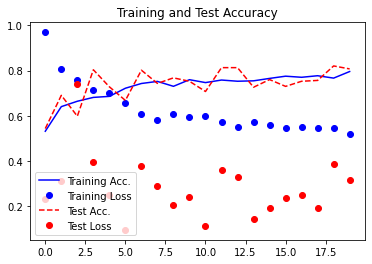

In [67]:
plot_training_history(history)

Después del entrenamiento también podemos evaluar el rendimiento del nuevo modelo en el conjunto de pruebas usando una sola llamada de función en la API de Keras.

In [68]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [69]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 80.75%


Podemos representar algunos ejemplos de imágenes mal clasificadas del conjunto de pruebas. Algunas de estas imágenes también son difíciles de clasificar para un humano.

La matriz de confusión muestra que el nuevo modelo está teniendo especialmente problemas para clasificar la clase *forky* (tenedor). Recordad que hemos usado sk-learn para representar la matriz, y las filas son clases verdades y las columnas clases predecidas. Esto puede ser debido a que tenemos muy pocos ejemplos de forky comparados con spoony y knifey, y aunque hayamos usado pesos de clases, no ha sido suficiente para compensar el desbalance.

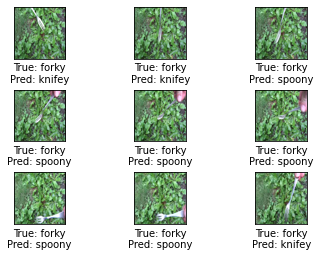

Matriz de confusión:
[[ 76  42  33]
 [  7 119  11]
 [  6   3 233]]
(0) forky
(1) knifey
(2) spoony


In [70]:
example_errors()

## 8. Fine-Tuning <a class="anchor" id="transferft"></a>

En Transfer Learning, el modelo original pre-entrenado se bloquea o congela durante el entrenamiento del nuevo clasificador. Esto asegura que los pesos del modelo original InceptionV3 no cambiarán. Una ventaja de esto es que el entrenamiento del nuevo clasificador no propagará grandes gradientes a través del modelo InceptionV3, lo que puede distorsionar sus pesos o causar un sobreajuste en el nuevo conjunto de datos.

Pero una vez que el nuevo clasificador ha sido entrenado, podemos tratar de afinar suavemente algunas de las capas más profundas del modelo InceptionV3 también. A esto lo llamamos "Ajuste fino", o **Fine Tuning**.

No está claro si Keras usa el booleano `trainable` en cada capa del modelo original InceptionV3 o si es anulado por el booleano `trainable` en la'meta-capa' que llamamos `conv_layer`. Así que habilitaremos el booleano `trainable` tanto para `conv_layer` como para todas las capas relevantes en el modelo original InceptionV3.

In [71]:
model.trainable = True

Queremos entrenar los últimos dos bloques de inception, es decir, congelamos las primeras 249 capas.

In [72]:
# elegimos entrenar los dos primeros bloques de inicio, es decir, vamos a congelar
# las primeras 249 capas y descongelar el resto:
# en otros ejemplos se encontró que era 172 en 249. 
# Tomamos 249 de acuerdo con https://keras.io/applications/
for layer in model.layers[249:]:
    layer.trainable = True

Podemos comprobar que esto ha actualizado el booleano `trainable` para las capas relevantes.

In [73]:
print_layer_trainable()

False:	input_2
False:	conv2d_95
False:	batch_normalization_95
False:	activation_95
False:	conv2d_96
False:	batch_normalization_96
False:	activation_96
False:	conv2d_97
False:	batch_normalization_97
False:	activation_97
False:	max_pooling2d_5
False:	conv2d_98
False:	batch_normalization_98
False:	activation_98
False:	conv2d_99
False:	batch_normalization_99
False:	activation_99
False:	max_pooling2d_6
False:	conv2d_103
False:	batch_normalization_103
False:	activation_103
False:	conv2d_101
False:	conv2d_104
False:	batch_normalization_101
False:	batch_normalization_104
False:	activation_101
False:	activation_104
False:	average_pooling2d_10
False:	conv2d_100
False:	conv2d_102
False:	conv2d_105
False:	conv2d_106
False:	batch_normalization_100
False:	batch_normalization_102
False:	batch_normalization_105
False:	batch_normalization_106
False:	activation_100
False:	activation_102
False:	activation_105
False:	activation_106
False:	mixed0
False:	conv2d_110
False:	batch_normalization_110
False:	acti

Usaremos un factor de aprendizaje bajo para el ajuste fino, para que los pesos del modelo InceptionV3 original solo cambien muy lentamente. No conviene permitir que estos pesos cambien demasiado.

In [74]:
optimizer_fine = RMSprop(lr=1e-6)

Dado que hemos definido un nuevo optimizador y hemos cambiado los booleanos `trainable` para muchas de las capas en el modelo, necesitamos recompilarlo para que los cambios hagan efecto.

In [75]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

Continuamos por tanto con el entrenamiento por donde lo dejamos anteriormente, ahora aplicando fine-tuning al modelo InceptionV3 y el nuevo clasificador.

In [76]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=30,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/30
100/100 [==============================] - 51s 509ms/step - loss: 0.4978 - categorical_accuracy: 0.7950 - val_loss: 0.3499 - val_categorical_accuracy: 0.8038
Epoch 2/30
100/100 [==============================] - 41s 406ms/step - loss: 0.4892 - categorical_accuracy: 0.7980 - val_loss: 0.3676 - val_categorical_accuracy: 0.7792
Epoch 3/30
100/100 [==============================] - 42s 425ms/step - loss: 0.4847 - categorical_accuracy: 0.7980 - val_loss: 0.3714 - val_categorical_accuracy: 0.7811
Epoch 4/30
100/100 [==============================] - 43s 426ms/step - loss: 0.4745 - categorical_accuracy: 0.8040 - val_loss: 0.3775 - val_categorical_accuracy: 0.7830
Epoch 5/30
100/100 [==============================] - 43s 427ms/step - loss: 0.4604 - categorical_accuracy: 0.8226 - val_loss: 0.3455 - val_categorical_accuracy: 0.7774
Epoch 6/30
100/100 [==============================] - 43s 427ms/step - loss: 0.4398 - categorical_accuracy: 0.8270 - val_loss: 0.3574 - val_categorical_acc

Luego podemos mostrar gráficamente los valores de pérdida y precisión de la clasificación a partir del entrenamiento. Dependiendo del conjunto de datos, el modelo original, el nuevo clasificador y los hiperparámetros como la velocidad de aprendizaje, esto puede mejorar las precisiones de clasificación tanto en el conjunto de entrenamiento como en el de pruebas, o puede mejorar el conjunto de entrenamiento pero empeorarla en el conjunto de pruebas en caso de sobreajuste. Es posible que se requiera cierta experimentación con los parámetros para hacer esto bien.

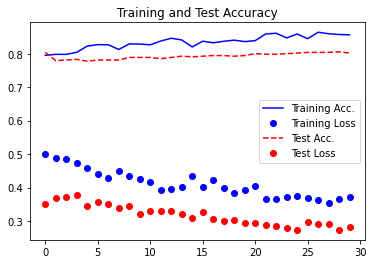

In [77]:
plot_training_history(history)

In [78]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [79]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 80.19%


Podemos volver a mostrar algunos ejemplos de imágenes mal clasificadas, y también podemos ver en la matriz de confusión que el modelo sigue teniendo problemas para clasificar correctamente los cuchillos y las cucharas, siendo muchas veces confundidos por los tenedores.

Una parte de la razón podría ser que el conjunto de entrenamiento contiene sólo 994 imágenes de tenedores, mientras que contiene 1.210 imágenes de cuchillos e imágenes de cucharas de 1.966. Aunque hemos ponderado las clases para compensar este desequilibrio, y también hemos aumentado el conjunto de entrenamiento transformando aleatoriamente las imágenes de diferentes maneras durante el entrenamiento, puede que no sea suficiente para que el modelo aprenda a reconocer correctamente los tenedores.

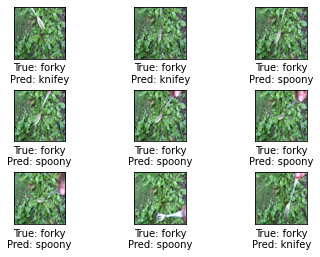

Matriz de confusión:
[[ 69  51  31]
 [  6 124   7]
 [  5   5 232]]
(0) forky
(1) knifey
(2) spoony


In [80]:
example_errors()

## 9. Conclusión <a class="anchor" id="transferconclu"></a>

Este pequeño tutorial ha mostrado cómo usar la API de Keras para TensorFlow para realizar tanto transfer learning como fine tuning del modelo InceptionV3 pre-entrenado en un nuevo conjunto de datos. 

Que el fine tuning mejore la precisión de la clasificación en comparación con solo usar transfer learning depende del modelo pre-entrenado, de la capa de transferencia que se elija, del conjunto de datos y de la forma en que se entrena el nuevo modelo. Puede que se experimente un mejor rendimiento con el ajuste fino, o puede que experimente un peor rendimiento si el modelo ajustado está sobreajustado a los datos de entrenamiento.

## License (MIT)

Based on the TensorFlow tutorials by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.